# Guide 2. Loading Bulk Stats and Viewing Them

This notebook is prepared for Moffat and Nichol by the NCSU Coastal Hazards Lab (Dr. Katherine Anarde, Levi Lavengood, Brooke Gaenzle, Elizabeth Farquhar) for the analysis, interpretation, and visualization of the bulk wave statistics for the data collected as part of the Frying Pan Shoals Hydrodynamic Characterization project (2024-2025). This is the second notebook in detailing specifically the processes and data from the bulk_stats _Sig1k.py script.

**Storage**

The bulk statistics are stored in h5 files like the other processed data files. The main difference for the bulk statistics, is that the groups that the processed data are stored in have been merged for the bulk statistics. This is possible since the bulk statistics are returned for every hour of sampling, so instead of the 14,400 samples per hour across multiple data fields we instead are left with just one averaged value per hour for each data field.

The bulk statistics are calculated in 1 hour averages which we call 'Chunks'. Each chunk consists of several overlapping 512 second segments called ensembles that are averaged together. We choose 512 second long ensembles since the length of the ensemble determines the max period of the waves we can observe, a shorter window and we may miss out on some longer period waves.

In [10]:
### Code to read in h5 files as detailed in the first guidebook
# Import necessary packages
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

dirpath = r'Z:\deployment_1\BulkStats\S0_103080'

files = os.listdir(dirpath) # list of files in Group 1

waves = {}
for file in files:
    file_path = os.path.join(dirpath, file)  # file path
    df = pd.read_hdf(file_path)  # read the file into a Pandas dataframe
    file_name = file.split('.')[0]  # file name 
    print(file_name)
    waves[file_name] = df  # store dataframe

GroupSpeed
WaveCelerity
MeanPeriod
SignificantWaveHeight
DepthAveragedNorthVeloctiy
DepthAveragedEastVeloctiy
MeanDirection1
MeaanSpread1
MeanDirection2
MeanSpread2
DepthAveragedFlowDireciton
Time


**Time**

The time data field stores the datetime assoicated with each chunk. It should be roughly evenly spaced one hour apart.

In [7]:
print(waves['Time'])

                            0
0  2024-08-20 11:30:00.125997
1  2024-08-20 12:30:00.125903
2  2024-08-20 13:30:00.126111
3  2024-08-20 14:30:00.125997
4  2024-08-20 15:30:00.126104
5  2024-08-20 16:30:00.126000
6  2024-08-20 17:30:00.126107
7  2024-08-20 18:30:00.126104
8  2024-08-20 19:30:00.126111
9  2024-08-20 20:30:00.126107
10 2024-08-20 21:30:00.126104
11 2024-08-20 22:30:00.125900
12 2024-08-20 23:30:00.126107
13 2024-08-21 00:30:00.126104
14 2024-08-21 01:30:00.126111
15 2024-08-21 02:30:00.126107
16 2024-08-21 03:30:00.126104
17 2024-08-21 04:30:00.126191
18 2024-08-21 05:30:00.126107
19 2024-08-21 06:30:00.126104
20 2024-08-21 07:30:00.126111
21 2024-08-21 08:30:00.126107
22 2024-08-21 09:30:00.126104
23 2024-08-21 10:30:00.126000


**Mean Period**

The mean wave period has units of XXX (seconds I think?). It is recorded as the average of the ensemble wave periods for each chunk. 

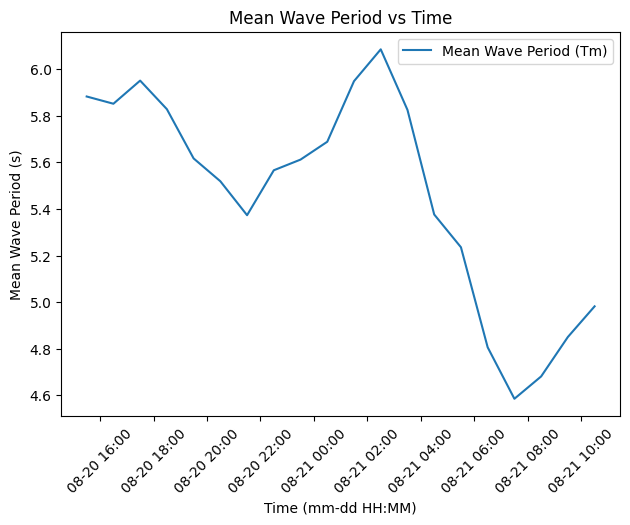

In [19]:
# Plot Mean Wave Period vs Time
plt.plot(waves["Time"], waves["MeanPeriod"], label="Mean Wave Period (Tm)")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.title("Mean Wave Period vs Time")
plt.legend()
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.show()

**Signifigant Wave Height**

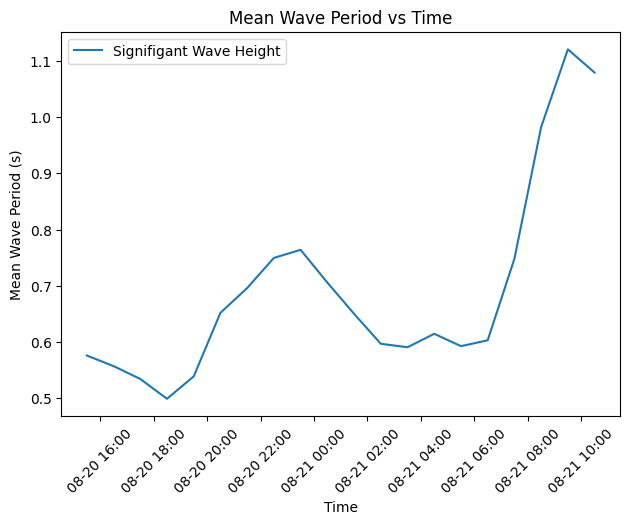

In [ ]:
# Plot Mean Wave Period vs Time
plt.plot(waves["Time"], waves["SignificantWaveHeight"], label="Signifigant Wave Height")

# Formatting
plt.xlabel("Time")
plt.ylabel("Signifigant Wave Height")
plt.title("Signifigant Wave Height vs Time")
plt.legend()
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.show()

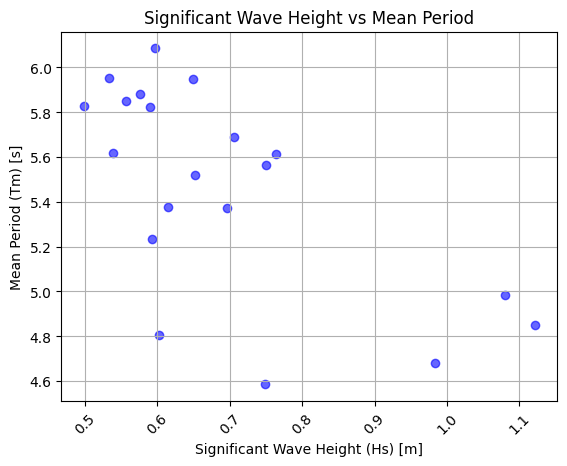

In [24]:
#Plot mean wave period vs signifigant wave height, you would expect larger waves to have longer periods
plt.scatter(waves['SignificantWaveHeight'], waves['MeanPeriod'], c='blue', alpha=0.6)
plt.title('Significant Wave Height vs Mean Period')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Group Wave Speed**

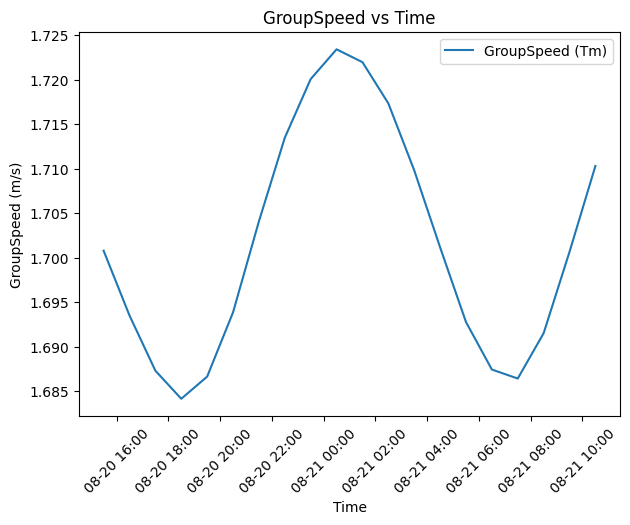

In [27]:
# Plot Group Wave Speed vs Time
plt.plot(waves["Time"], waves["GroupSpeed"], label="GroupSpeed (Tm)")

# Formatting
plt.xlabel("Time")
plt.ylabel("GroupSpeed (m/s)")
plt.title("GroupSpeed vs Time")
plt.legend()
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.show()

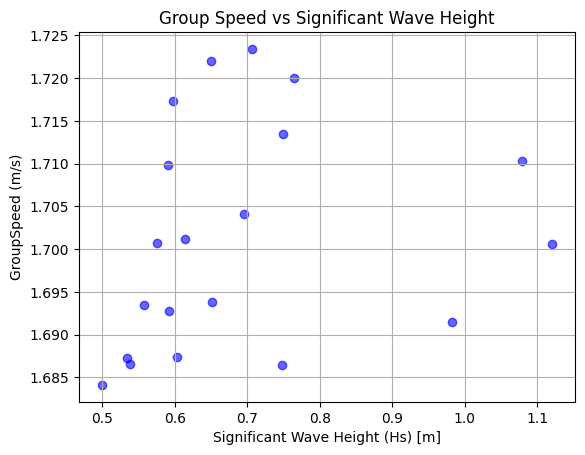

In [29]:
#Look at correlation between wave height and wave group speed
plt.scatter(waves['SignificantWaveHeight'], waves['GroupSpeed'], c='blue', alpha=0.6)
plt.title('Group Speed vs Significant Wave Height')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel("GroupSpeed (m/s)")
plt.grid(True)
plt.show()

**Wave Direction and Spread**

**Depth Averaged Current Velocity**

**Depth Averaged Current Direction**

**Wave Celerity, Wave Number, Frequency Range**